In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import os 
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.1.0
sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)
matplotlib 3.0.3
numpy 1.18.2
pandas 0.25.1
sklearn 0.20.1
tensorflow 2.1.0
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf


In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
import pprint

pprint.pprint(housing.data[0:5])
pprint.pprint(housing.target[0:5])

array([[ 8.32520000e+00,  4.10000000e+01,  6.98412698e+00,
         1.02380952e+00,  3.22000000e+02,  2.55555556e+00,
         3.78800000e+01, -1.22230000e+02],
       [ 8.30140000e+00,  2.10000000e+01,  6.23813708e+00,
         9.71880492e-01,  2.40100000e+03,  2.10984183e+00,
         3.78600000e+01, -1.22220000e+02],
       [ 7.25740000e+00,  5.20000000e+01,  8.28813559e+00,
         1.07344633e+00,  4.96000000e+02,  2.80225989e+00,
         3.78500000e+01, -1.22240000e+02],
       [ 5.64310000e+00,  5.20000000e+01,  5.81735160e+00,
         1.07305936e+00,  5.58000000e+02,  2.54794521e+00,
         3.78500000e+01, -1.22250000e+02],
       [ 3.84620000e+00,  5.20000000e+01,  6.28185328e+00,
         1.08108108e+00,  5.65000000e+02,  2.18146718e+00,
         3.78500000e+01, -1.22250000e+02]])
array([4.526, 3.585, 3.521, 3.413, 3.422])


In [4]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(housing.data, housing.target, random_state=2020)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, random_state=211)

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [5]:
x_train.shape[1:]

(8,)

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaler = scaler.fit_transform(x_train)
x_valid_scaler = scaler.transform(x_valid)
x_test_scaler = scaler.transform(x_test)

In [7]:
# 函数式API 功能API进行Wide-Deep编程
input = keras.layers.Input(shape=x_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation='relu')(input)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
# 复合函数: f(x) = h(g(x))
concat = keras.layers.concatenate([input, hidden2])
output = keras.layers.Dense(1)(concat)

model = keras.models.Model(inputs=[input], outputs=[output])

model.summary()
model.compile(loss="mean_squared_error", optimizer="sgd")
callbakes = [keras.callbacks.EarlyStopping(patience=5,min_delta=1e-2)]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           930         dense[0][0]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_1[0][0]                

In [8]:
history = model.fit(x_train_scaler, y_train,
                   validation_data=(x_valid_scaler, y_valid),
                   epochs=100,
                   callbacks=callbakes)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 72us/sample - loss: 1.0036 - val_loss: 0.5451
Epoch 2/100
11610/11610 [==============================] - 0s 39us/sample - loss: 0.5300 - val_loss: 0.6026
Epoch 3/100
11610/11610 [==============================] - 0s 40us/sample - loss: 0.9525 - val_loss: 2.6327
Epoch 4/100
11610/11610 [==============================] - 0s 38us/sample - loss: 8.5385 - val_loss: 118.9273
Epoch 5/100
11610/11610 [==============================] - 0s 39us/sample - loss: 57.0528 - val_loss: 159.4713
Epoch 6/100
11610/11610 [==============================] - 0s 37us/sample - loss: nan - val_loss: nan


C:\Users\Shy\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\keras\callbacks.py:1261: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


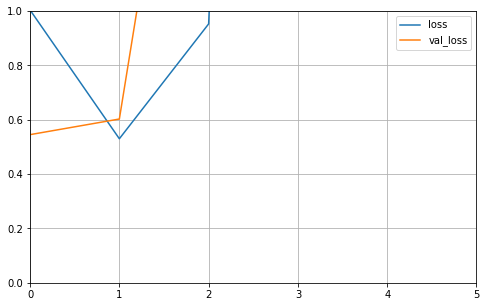

In [9]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
    
plot_learning_curves(history)

In [10]:
model.evaluate(x_test_scaler, y_test)

5160/5160 [==============================] - 0s 20us/sample - loss: nan


nan

In [11]:
# 使用子类API来实现Wide_Deep
class WideDeepModel(keras.models.Model):
    def __init__(self):
        super(WideDeepModel, self).__init__()
        """定义模型的层次"""
        self.hidden1_layer = keras.layers.Dense(30, activation='relu')
        self.hidden2_layer = keras.layers.Dense(30, activation='relu')
        self.output_layer = keras.layers.Dense(1)
        
    def call(self, input):
        """完成模型的正向计算"""
        hidden1 = self.hidden1_layer(input)
        hidden2 - self.hidden2_layer(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_layer(concat)
        return output
    
model = WideDeepModel()
model.build(input_shape=(None, 8))

model.summary()
model.compile(loss="mean_squared_error", optimizer="sgd")
callbakes = [keras.callbacks.EarlyStopping(patience=5,min_delta=1e-2)]

Model: "wide_deep_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              multiple                  270       
_________________________________________________________________
dense_4 (Dense)              multiple                  930       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 39        
Total params: 1,239
Trainable params: 1,239
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(x_train_scaler, y_train,
                   validation_data=(x_valid_scaler, y_valid),
                   epochs=100,
                   callbacks=callbakes)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
   32/11610 [..............................] - ETA: 41sWARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: 


_SymbolicException: Inputs to eager execution function cannot be Keras symbolic tensors, but found [<tf.Tensor 'dense_1/Identity:0' shape=(None, 30) dtype=float32>]

In [17]:
# 多输入
input_wide = keras.layers.Input(shape=[5])
input_deep = keras.layers.Input(shape=[6])
hidden1 = keras.layers.Dense(30, activation='relu')(input_deep)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([input_wide, hidden2])
output = keras.layers.Dense(1)(concat)

model = keras.models.Model(inputs = [input_wide, input_deep], 
                           outputs=[output])
model.summary()
model.compile(loss="mean_squared_error", optimizer="adam")
callbakes = [keras.callbacks.EarlyStopping(patience=5,min_delta=1e-2)]

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 30)           210         input_11[0][0]                   
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 30)           930         dense_16[0][0]                   
____________________________________________________________________________________________

In [18]:
x_train_scaled_wide = x_train_scaler[:, :5]
x_train_scaled_deep = x_train_scaler[:, 2:]
x_valid_scaled_wide = x_valid_scaler[:, :5]
x_valid_scaled_deep = x_valid_scaler[:, 2:]
x_test_scaled_wide = x_test_scaler[:, :5]
x_test_scaled_deep = x_test_scaler[:, 2:]

history = model.fit([x_train_scaled_wide,x_train_scaled_deep], 
                    y_train,
                   validation_data=([x_valid_scaled_wide,
                                     x_valid_scaled_deep], 
                                    y_valid),
                   epochs=100,
                   callbacks=callbakes)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 67us/sample - loss: 1.5969 - val_loss: 0.6989
Epoch 2/100
11610/11610 [==============================] - 1s 46us/sample - loss: 0.5595 - val_loss: 0.5052
Epoch 3/100
11610/11610 [==============================] - 0s 39us/sample - loss: 0.4498 - val_loss: 0.4524
Epoch 4/100
11610/11610 [==============================] - 0s 41us/sample - loss: 0.4057 - val_loss: 0.4104
Epoch 5/100
11610/11610 [==============================] - 0s 41us/sample - loss: 0.3811 - val_loss: 0.3953
Epoch 6/100
11610/11610 [==============================] - 1s 44us/sample - loss: 0.3669 - val_loss: 0.3771
Epoch 7/100
11610/11610 [==============================] - 0s 42us/sample - loss: 0.3536 - val_loss: 0.3742
Epoch 8/100
11610/11610 [==============================] - 0s 41us/sample - loss: 0.3434 - val_loss: 0.3659
Epoch 9/100
11610/11610 [==============================] - 0s 42us/sample - loss: 0.345

In [ ]:
# 多输出


In [ ]:
# RandomizedSearchCV
# 1. 转化为sklearn得model
# 2. 定义参数集合
# 3. 搜索参数

def build_model(hidden_layers = 1,
               layer_size = 30,
               learning_rate = 3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size,
                                 activation='relu',
                                input_shape=x_train.shape[1:]))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size,activation='relu'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss='mse', optimizer=optimizer)
    return model